# Get probabilistic mass measurements for Kepler-431 using Forecaster.

In [1]:
import numpy as np
import forecaster.mr_forecast as mr
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import pandas as pd
import time
import pickle 
from collections import OrderedDict
from generatefeatures import generate_features
%matplotlib inline

Get mass samples for Kepler-431 using data from NASAEA and Morton et al. (2016) - http://adsabs.harvard.edu/abs/2016ApJ...822...86M

In [11]:
#mean/std radius measurements, earth radii
mu1, std1 = 0.77, 0.15    
mu2, std2 = 0.76, 0.15
mu3, std3 = 1.08, 0.205

n_samples = 1200

#generate samples from normal distribution
r1 = np.random.normal(mu1,std1,n_samples)
r2 = np.random.normal(mu2,std2,n_samples)
r3 = np.random.normal(mu3,std3,n_samples)

#radius samples -> probabilistic mass samples
m1 = mr.Rpost2M(r1, unit='Earth', grid_size=1e3, classify='Yes')  #earth masses
m2 = mr.Rpost2M(r2, unit='Earth', grid_size=1e3, classify='Yes')
m3 = mr.Rpost2M(r3, unit='Earth', grid_size=1e3, classify='Yes')

Terran 94.4 %, Neptunian 5.6 %, Jovian 0.0 %, Star 0.0 %
Terran 94.6 %, Neptunian 5.4 %, Jovian 0.0 %, Star 0.0 %
Terran 72.0 %, Neptunian 28.0 %, Jovian 0.0 %, Star 0.0 %


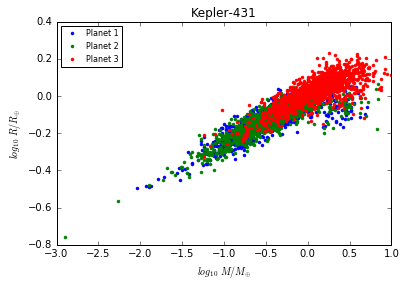

In [12]:
plt.plot(np.log10(m1), np.log10(r1), '.', label='Planet 1')
plt.plot(np.log10(m2), np.log10(r2), '.', label='Planet 2')
plt.plot(np.log10(m3), np.log10(r3), '.', label='Planet 3')
plt.xlabel(r'$log_{10}\ M/M_{\oplus}$')
plt.ylabel(r'$log_{10}\ R/R_{\oplus}$')
plt.legend(loc='upper left', numpoints=1, fontsize=8)
plt.title('Kepler-431')

## Generate Dataframe for Kepler-431

In [13]:
from random import random, uniform, seed
def draw_e(P1,P2,P3,m1,m2,m3,Ms):
    a1, a2, a3 = ((P1/365)**2 * Ms)**(1./3.), ((P2/365)**2 * Ms)**(1./3.), ((P3/365)**2 * Ms)**(1./3.)

    ecrit1 = (a2-a1)/a1
    ecrit21 = (a2-a1)/a2
    ecrit23 = (a3-a2)/a2
    ecrit3 = (a3-a2)/a3

    logemax1 = np.log10(ecrit1)
    logemax2 = np.log10(min(ecrit21, ecrit23))
    logemax3 = np.log10(ecrit3)

    earth = 0.000003003
    logemin1 = np.log10(m2*earth/ecrit1**2)
    logemin2 = np.log10(max(m1*earth/ecrit21**2, m3*earth/ecrit23**2))
    logemin3 = np.log10(m2*earth/ecrit3**2)
    
    e1 = min(10.**uniform(logemin1, logemax1), 1.) # make sure ecc < 1
    e2 = min(10.**uniform(logemin2, logemax2), 1.)
    e3 = min(10.**uniform(logemin3, logemax3), 1.)
    return e1, e2, e3

In [14]:
Ms = 1.071                            #Solar mass units
P1, P2, P3 = 6.803, 8.703, 11.922     #days
w1, w2, w3 = 2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples)
MA1, MA2, MA3 = 2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples)
e = []
for i in range(n_samples):
    e.append(draw_e(P1,P2,P3,m1[i],m2[i],m3[i],Ms))
e1, e2, e3 = zip(*np.asarray(e))

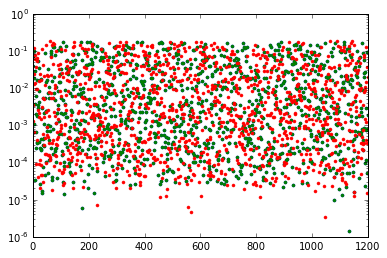

In [15]:
plt.plot(e1, '.')
plt.plot(e1, '.')
plt.plot(e3, '.')
plt.yscale('log')

In [16]:
#make dataframe
data = []
for i in range(n_samples):
    data.append([m1[i],MA1[i],P1,e1[i],w1[i],m2[i],MA2[i],P2,e2[i],w2[i],m3[i],MA3[i],P3,e3[i],w3[i]])
data = pd.DataFrame(np.asarray(data),columns=["m1","MA1","P1","e1","w1","m2","MA2","P2","e2","w2","m3","MA3","P3","e3","w3"])

In [17]:
data.head()

,m1,MA1,P1,e1,w1,m2,MA2,P2,e2,w2,m3,MA3,P3,e3,w3
0,1.942618,3.623121,6.803,0.038493,5.631510,1.064523,4.379513,8.703,0.001695,6.164372,1.086834,2.266119,11.922,0.003531,3.836148
1,0.115691,3.221486,6.803,0.074622,0.133812,0.525875,3.381358,8.703,0.001076,0.889384,0.796238,0.592054,11.922,0.001260,5.807961
2,0.157913,5.208483,6.803,0.001055,5.108792,0.319662,3.891360,8.703,0.017883,5.100157,1.132868,0.995850,11.922,0.023905,1.382668
3,0.763883,4.053768,6.803,0.000639,0.543045,0.717799,4.828054,8.703,0.000207,3.788220,2.293250,4.423867,11.922,0.012976,0.233198
4,0.128333,2.872688,6.803,0.018934,3.516731,0.347314,4.913331,8.703,0.000171,3.800843,1.863680,0.707787,11.922,0.122328,5.573243


In [20]:
def predict_system(system,data,Ms,n_sims,model,save_data,epoch=0):
    
    # run models
    start = time.time()
    fullfeatures = []
    for index, d in data.iterrows():
        fullfeatures.append(generate_features(d, Ms, epoch))
        print index
    print "%d simulations took %f seconds"%(n_sims, time.time() - start)
    
    model = pickle.load(open('OptimalXGBmodel.pkl', 'rb'))
    
    features = []
    features += ['avg_iH1', 'avg_iH2']
    features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
    features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
    features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
    features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
    features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
    features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
    features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
    features += ['Lyapunov_time']
    
    # compile results - take only the features the model uses
    results = pd.DataFrame(columns=features)
    for i in range(len(fullfeatures)):
        results.loc[i] = fullfeatures[i][features] 
        
    # predict stability 
    results["predict_proba"] = model.predict_proba(results)[:,1]
    
    data.to_csv("systems/%s_data.csv"%system)
    results.to_csv("systems/%s_results.csv"%system)
    return data, results

Run system, will take a second

In [21]:
model = "OptimalXGBmodel.pkl"   #pre-trained machine learning model
save_data = 1

#run
data, results = predict_system("Kepler-431",data,Ms,n_samples,model,save_data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [22]:
data.head()

,m1,MA1,P1,e1,w1,m2,MA2,P2,e2,w2,m3,MA3,P3,e3,w3
0,1.942618,3.623121,6.803,0.038493,5.631510,1.064523,4.379513,8.703,0.001695,6.164372,1.086834,2.266119,11.922,0.003531,3.836148
1,0.115691,3.221486,6.803,0.074622,0.133812,0.525875,3.381358,8.703,0.001076,0.889384,0.796238,0.592054,11.922,0.001260,5.807961
2,0.157913,5.208483,6.803,0.001055,5.108792,0.319662,3.891360,8.703,0.017883,5.100157,1.132868,0.995850,11.922,0.023905,1.382668
3,0.763883,4.053768,6.803,0.000639,0.543045,0.717799,4.828054,8.703,0.000207,3.788220,2.293250,4.423867,11.922,0.012976,0.233198
4,0.128333,2.872688,6.803,0.018934,3.516731,0.347314,4.913331,8.703,0.000171,3.800843,1.863680,0.707787,11.922,0.122328,5.573243


Analyze a particular system

In [23]:
results.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a1_slope,norm_a2_slope,norm_a3_slope,Lyapunov_time,predict_proba
0,0.0,0.0,0.000037,0.000128,0.000044,0.000082,0.000072,0.000217,0.000077,0.000149,...,0.011193,0.0,0.0,0.101364,0.018487,-1.930220e-12,9.321284e-12,-9.753924e-12,604.179043,0.232487
1,0.0,0.0,0.000048,0.000094,0.000044,0.000079,0.000016,0.000046,0.000018,0.000046,...,0.004083,0.0,0.0,0.010352,0.006660,3.047940e-12,-2.673562e-12,1.259480e-12,725.243871,0.967528
2,0.0,0.0,0.000010,0.000037,0.000007,0.000011,0.000026,0.000103,0.000043,0.000092,...,0.118096,0.0,0.0,0.126372,0.114347,2.667952e-12,-9.210305e-12,1.405119e-12,1357.900806,0.982407
3,0.0,0.0,0.000018,0.000075,0.000014,0.000023,0.000038,0.000160,0.000013,0.000022,...,0.001187,0.0,0.0,0.069090,0.059656,-4.512916e-12,-5.559726e-13,2.575023e-12,3956.655415,0.999430
4,0.0,0.0,0.001222,0.003746,0.000108,0.000157,0.000784,0.002741,0.000339,0.000660,...,0.001132,0.0,0.0,0.646726,0.537953,3.029428e-09,-1.455756e-09,3.213135e-11,215.440145,0.001047


In [44]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0

def get_rhill(d,Ms):
    earth = 0.000003003
    a1,a2 = ((d["P1"]/365)**2 * Ms)**(1./3.), ((d["P2"]/365)**2 * Ms)**(1./3.)
    hill12 = a1*((d["m1"]+d["m2"])*earth/Ms/3.)**(1./3.)
    hill23 = a2*((d["m2"]+d["m3"])*earth/Ms/3.)**(1./3.)
    return max(hill12,hill23)

In [45]:
import rebound
sim = rebound.Simulation()
sim.getWidget(scale=0.1)

In [46]:
sys = 3

d = data.iloc[sys]
sim.integrator = 'whfast'
sim.G = 1
sim.collision_resolve = collision
sim.add(m=Ms) # add a star

In [47]:
maxhill = get_rhill(d,Ms)
earth = 0.000003003
for i in range(1,4):
    sim.add(m=d["m%d"%i]*earth*Ms,P=d["P%d"%i]*2*np.pi/365.,e=d["e%d"%i],omega=d["w%d"%i],M=d["MA%d"%i],r=maxhill) 
sim.move_to_com() # Move to the centre of mass frame

P0 = sim.particles[1].P
sim.dt = P0/20.

In [48]:
sim.integrate(1e5*P0)